## Required Libraries Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_curve, auc
from scipy.stats import uniform
from sklearn.multiclass import OneVsRestClassifier
RANDOM_STATE = 42 # For reproducibility

## Dataset Loading

In [2]:
# Load the main dataset
main_df = pd.read_csv('brain_mri_features.csv')

# Load the selected feature names from the CSV
features_df = pd.read_csv('selected_features.csv')
selected_features = features_df['Selected_Features'].tolist()

# Split data into features and target class
X = main_df[selected_features]  # Selected features data
y = main_df['class']  # ['Alzheimer', 'Parkinson', 'Normal']

# Standardize features to mean = 0 and variance = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Stratified Train-Test Split (80% Training, 20% Testing, Maintaining class ratios by stratifying)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

## Hyperparameter Tuning

In [ ]:
# Note that this cell takes some minutes to finish running due to computationally expensive parameters of randomized search
# Define hyperparameter distribution for random search
param_dist = {
    'estimator__C': uniform(0.1, 10),  # Regularization parameter (prevents overrfitting)
    'estimator__kernel': ['linear', 'rbf'], # Kernel Type (linear, RBF)
    'estimator__gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 5)), # Kernel coefficient (controls the spread of the kernel)
}

# Create SVM classifier with One-vs-Rest strategy for multiclass
svc = OneVsRestClassifier(svm.SVC(probability=True, random_state=RANDOM_STATE)) # Probability parameter enables probability estimates (required for ROC curves)

# Setup randomized search with stratified 5-fold cross-validation for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), # Maintain class distribution in the 5 folds
    scoring='accuracy', # Optimization metric
    n_jobs=4,
    random_state=RANDOM_STATE,
)

# Perform hyperparameter search
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Best Parameters: {'estimator__C': np.float64(9.522017556848526), 'estimator__gamma': np.float64(5.623413251903491), 'estimator__kernel': 'rbf'}
Best CV Accuracy: 0.8682457746049179


## Model Training

In [4]:
# Final Model Training & Evaluation
best_svm = random_search.best_estimator_
best_svm.fit(X_train, y_train)

# Make predictions
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)

# Compare Test accuracy with training accuracy to check for overfitting
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = best_svm.score(X_train, y_train)

## Showcasing Performance Metrics

In [5]:
# Return accuracy for each class
def class_accuracy(y_true, y_pred, classes):
    class_acc = {}
    for cls in classes:
        idx = (y_true == cls)
        class_acc[cls] = accuracy_score(y_true[idx], y_pred[idx])
    return class_acc

print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print(f"Training Set Accuracy: {train_accuracy:.4f}")

cls_acc = class_accuracy(y_test, y_pred, y.unique())
print("\nClass-wise Accuracy:")
for target_class, accurracy in cls_acc.items():
    print(f"{target_class}: {accurracy:.4f}")

# Performance Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y.unique()))


Test Set Accuracy: 0.8755
Training Set Accuracy: 0.9386

Class-wise Accuracy:
alzheimer: 0.8520
parkinson: 0.9749
normal: 0.8093

Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.81      0.85      0.83       500
   parkinson       0.84      0.81      0.82       540
      normal       0.99      0.97      0.98       478

    accuracy                           0.88      1518
   macro avg       0.88      0.88      0.88      1518
weighted avg       0.88      0.88      0.88      1518



## Plotting Confusion Matrix & ROC Curve

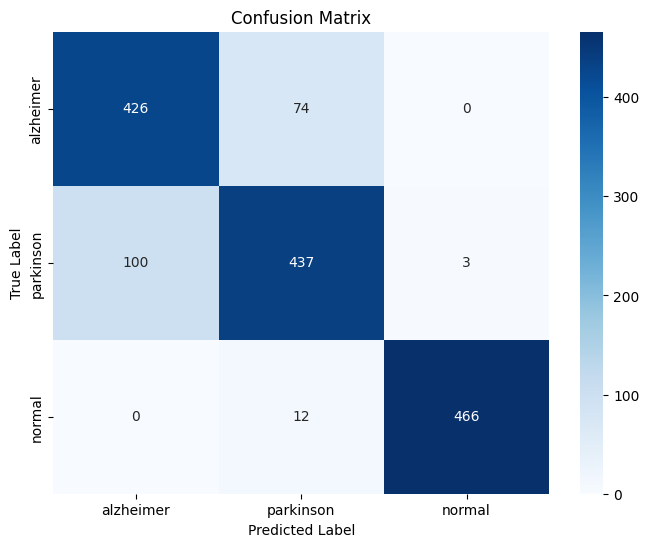

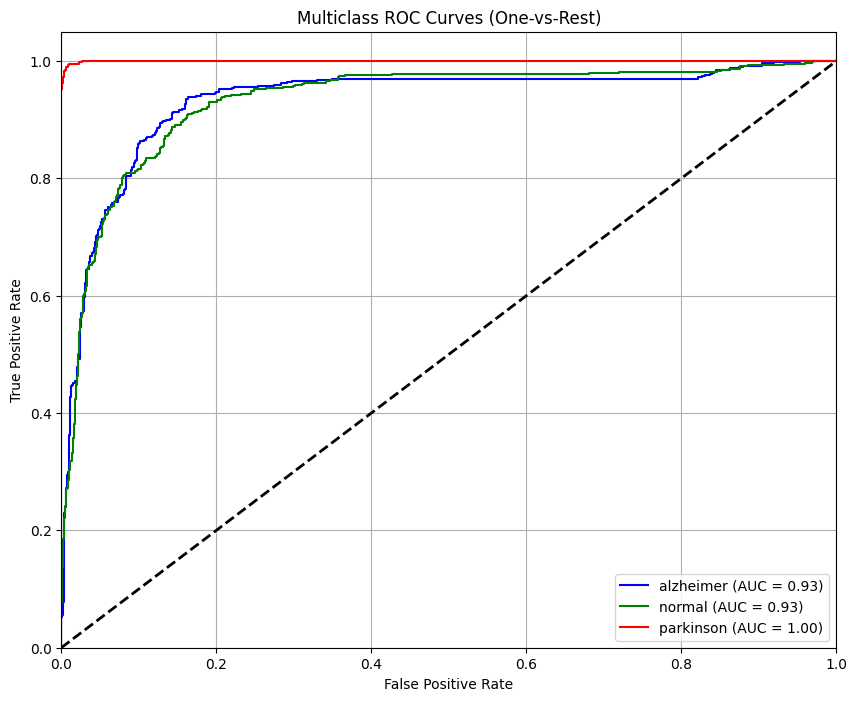

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve_one_vs_rest(y_true, y_proba, class_names):
    # Convert labels to binary format for each class
    class_names = best_svm.classes_
    y_true_bin  = label_binarize(y_true, classes=class_names)
    
    # Initialize storage for ROC metrics
    fpr, tpr, roc_auc = {}, {}, {}

    # Calculate ROC metrics for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red']  # Each color has a class
    
    for i, color, class_name in zip(range(len(class_names)), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_confusion_matrix(y_test, y_pred, classes=y.unique())
plot_roc_curve_one_vs_rest(y_test, y_proba, y.unique())